## Module 6: MLflow Governance for Data & Models
### 1 Hour

This module covers:
* **Monitoring Data Freshness & Feature Drift** - Track data quality and feature changes over time
* **Explainability for Business & Regulatory Teams** - Make ML models interpretable and compliant

### Demo 1: Monitoring Data Freshness & Feature Drift

**Objectives:**
* Track data freshness for ML features
* Detect feature drift in production
* Monitor feature distributions over time
* Alert on data quality degradation

In [0]:
# Create sample feature dataset for ML model
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

# Set random seed for reproducibility
np.random.seed(42)

# Generate baseline training data (30 days ago)
print("Creating baseline training dataset...")

training_size = 1000
training_date = datetime.now() - timedelta(days=30)

training_data = pd.DataFrame({
    'customer_id': [f'CUST{i:05d}' for i in range(training_size)],
    'age': np.random.normal(45, 15, training_size).clip(18, 80),
    'income': np.random.normal(75000, 25000, training_size).clip(20000, 200000),
    'credit_score': np.random.normal(700, 80, training_size).clip(300, 850),
    'account_balance': np.random.normal(5000, 3000, training_size).clip(0, 50000),
    'num_transactions': np.random.poisson(15, training_size),
    'avg_transaction_amount': np.random.normal(250, 100, training_size).clip(10, 2000),
    'days_since_last_login': np.random.exponential(7, training_size).clip(0, 90),
    'data_timestamp': training_date,
    'dataset_type': 'training'
})

# Add target variable (churn prediction)
training_data['churn'] = (
    (training_data['days_since_last_login'] > 30) | 
    (training_data['num_transactions'] < 5) |
    (training_data['account_balance'] < 1000)
).astype(int)

print(f"✓ Created training dataset: {len(training_data)} records")
print(f"  Churn rate: {training_data['churn'].mean()*100:.2f}%")
print(f"\nTraining data summary:")
print(training_data[['age', 'income', 'credit_score', 'num_transactions']].describe())

Creating baseline training dataset...
✓ Created training dataset: 1000 records
  Churn rate: 11.20%

Training data summary:
               age         income  credit_score  num_transactions
count  1000.000000    1000.000000   1000.000000       1000.000000
mean     45.376027   76914.502456    699.474183         14.998000
std      14.193475   24565.388593     76.269267          3.841191
min      18.000000   20000.000000    458.439028          5.000000
25%      35.286145   59843.957774    648.160031         12.000000
50%      45.379509   76576.928308    699.979939         15.000000
75%      54.719158   93222.054426    752.873225         17.000000
max      80.000000  154827.689196    850.000000         28.000000


In [0]:
# Generate production data with feature drift
print("Creating production dataset with feature drift...\n")

production_size = 500
production_date = datetime.now()

# Introduce drift: age distribution shifts, income decreases, fewer transactions
production_data = pd.DataFrame({
    'customer_id': [f'CUST{i+training_size:05d}' for i in range(production_size)],
    'age': np.random.normal(38, 12, production_size).clip(18, 80),  # Younger customers
    'income': np.random.normal(65000, 22000, production_size).clip(20000, 200000),  # Lower income
    'credit_score': np.random.normal(680, 85, production_size).clip(300, 850),  # Lower scores
    'account_balance': np.random.normal(4200, 2800, production_size).clip(0, 50000),  # Lower balance
    'num_transactions': np.random.poisson(12, production_size),  # Fewer transactions
    'avg_transaction_amount': np.random.normal(220, 95, production_size).clip(10, 2000),  # Lower amounts
    'days_since_last_login': np.random.exponential(10, production_size).clip(0, 90),  # Less active
    'data_timestamp': production_date,
    'dataset_type': 'production'
})

production_data['churn'] = (
    (production_data['days_since_last_login'] > 30) | 
    (production_data['num_transactions'] < 5) |
    (production_data['account_balance'] < 1000)
).astype(int)

print(f"✓ Created production dataset: {len(production_data)} records")
print(f"  Churn rate: {production_data['churn'].mean()*100:.2f}%")
print(f"\nProduction data summary:")
print(production_data[['age', 'income', 'credit_score', 'num_transactions']].describe())

Creating production dataset with feature drift...

✓ Created production dataset: 500 records
  Churn rate: 18.80%

Production data summary:
              age         income  credit_score  num_transactions
count  500.000000     500.000000    500.000000        500.000000
mean    38.667863   66274.869923    678.972971         11.784000
std     12.022629   21847.179566     79.949885          3.442826
min     18.000000   20000.000000    465.663592          3.000000
25%     30.438189   51164.457449    626.245680          9.000000
50%     37.854047   66980.209186    678.915091         11.000000
75%     47.342856   80348.947993    733.202155         14.000000
max     78.528595  134470.968227    850.000000         24.000000


In [0]:
# Log feature statistics to MLflow for monitoring
import mlflow
import mlflow.sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Set MLflow experiment
mlflow.set_experiment("/Users/avyukti@training3411.onmicrosoft.com/data-quality-governance")

print("Logging baseline training statistics to MLflow...\n")

# Start MLflow run for baseline
with mlflow.start_run(run_name="baseline_training_features") as run:
    
    # Log feature statistics
    feature_cols = ['age', 'income', 'credit_score', 'account_balance', 
                    'num_transactions', 'avg_transaction_amount', 'days_since_last_login']
    
    for col in feature_cols:
        mlflow.log_metric(f"{col}_mean", training_data[col].mean())
        mlflow.log_metric(f"{col}_std", training_data[col].std())
        mlflow.log_metric(f"{col}_min", training_data[col].min())
        mlflow.log_metric(f"{col}_max", training_data[col].max())
        mlflow.log_metric(f"{col}_median", training_data[col].median())
    
    # Log data freshness
    mlflow.log_param("data_timestamp", str(training_date))
    mlflow.log_param("dataset_type", "training")
    mlflow.log_param("record_count", len(training_data))
    mlflow.log_metric("churn_rate", training_data['churn'].mean())
    
    # Train a simple model
    X = training_data[feature_cols]
    y = training_data['churn']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    # Log model metrics
    y_pred = model.predict(X_test)
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))
    mlflow.log_metric("precision", precision_score(y_test, y_pred))
    mlflow.log_metric("recall", recall_score(y_test, y_pred))
    mlflow.log_metric("f1_score", f1_score(y_test, y_pred))
    
    # Log model
    mlflow.sklearn.log_model(model, "model")
    
    baseline_run_id = run.info.run_id
    print(f"✓ Baseline run logged: {baseline_run_id}")
    print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"  F1 Score: {f1_score(y_test, y_pred):.4f}")

2026/01/18 16:12:21 INFO mlflow.tracking.fluent: Experiment with name '/Users/avyukti@training3411.onmicrosoft.com/data-quality-governance' does not exist. Creating a new experiment.


Logging baseline training statistics to MLflow...



2026/01/18 16:12:29 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


✓ Baseline run logged: c2b2562334814c77bbe660390a078db8
  Accuracy: 0.9950
  F1 Score: 0.9697


In [0]:
# Detect feature drift between training and production
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

print("="*70)
print("FEATURE DRIFT DETECTION")
print("="*70)

feature_cols = ['age', 'income', 'credit_score', 'account_balance', 
                'num_transactions', 'avg_transaction_amount', 'days_since_last_login']

drift_results = []

for col in feature_cols:
    # Calculate statistics
    train_mean = training_data[col].mean()
    prod_mean = production_data[col].mean()
    train_std = training_data[col].std()
    prod_std = production_data[col].std()
    
    # Calculate percentage change
    mean_change_pct = ((prod_mean - train_mean) / train_mean * 100)
    std_change_pct = ((prod_std - train_std) / train_std * 100)
    
    # Perform Kolmogorov-Smirnov test for distribution drift
    ks_statistic, ks_pvalue = stats.ks_2samp(training_data[col], production_data[col])
    
    # Determine drift severity
    if ks_pvalue < 0.01:
        drift_severity = "CRITICAL"
    elif ks_pvalue < 0.05:
        drift_severity = "HIGH"
    elif abs(mean_change_pct) > 10:
        drift_severity = "MEDIUM"
    else:
        drift_severity = "LOW"
    
    drift_results.append({
        'feature': col,
        'train_mean': train_mean,
        'prod_mean': prod_mean,
        'mean_change_pct': mean_change_pct,
        'ks_statistic': ks_statistic,
        'ks_pvalue': ks_pvalue,
        'drift_severity': drift_severity
    })
    
    print(f"\n{col}:")
    print(f"  Training mean: {train_mean:.2f}")
    print(f"  Production mean: {prod_mean:.2f}")
    print(f"  Change: {mean_change_pct:+.2f}%")
    print(f"  KS statistic: {ks_statistic:.4f} (p-value: {ks_pvalue:.4f})")
    print(f"  Drift severity: {drift_severity}")

print("\n" + "="*70)

FEATURE DRIFT DETECTION

age:
  Training mean: 45.38
  Production mean: 38.67
  Change: -14.78%
  KS statistic: 0.2210 (p-value: 0.0000)
  Drift severity: CRITICAL

income:
  Training mean: 76914.50
  Production mean: 66274.87
  Change: -13.83%
  KS statistic: 0.1940 (p-value: 0.0000)
  Drift severity: CRITICAL

credit_score:
  Training mean: 699.47
  Production mean: 678.97
  Change: -2.93%
  KS statistic: 0.1140 (p-value: 0.0003)
  Drift severity: CRITICAL

account_balance:
  Training mean: 5010.99
  Production mean: 4236.61
  Change: -15.45%
  KS statistic: 0.1550 (p-value: 0.0000)
  Drift severity: CRITICAL

num_transactions:
  Training mean: 15.00
  Production mean: 11.78
  Change: -21.43%
  KS statistic: 0.3540 (p-value: 0.0000)
  Drift severity: CRITICAL

avg_transaction_amount:
  Training mean: 247.09
  Production mean: 219.99
  Change: -10.97%
  KS statistic: 0.1260 (p-value: 0.0000)
  Drift severity: CRITICAL

days_since_last_login:
  Training mean: 6.78
  Production mean: 10

In [0]:
# Log production data statistics and drift metrics
print("Logging production statistics and drift metrics to MLflow...\n")

with mlflow.start_run(run_name="production_features_with_drift") as run:
    
    # Log production feature statistics
    for col in feature_cols:
        mlflow.log_metric(f"{col}_mean", production_data[col].mean())
        mlflow.log_metric(f"{col}_std", production_data[col].std())
        mlflow.log_metric(f"{col}_min", production_data[col].min())
        mlflow.log_metric(f"{col}_max", production_data[col].max())
        mlflow.log_metric(f"{col}_median", production_data[col].median())
    
    # Log drift metrics
    for result in drift_results:
        mlflow.log_metric(f"{result['feature']}_drift_pct", result['mean_change_pct'])
        mlflow.log_metric(f"{result['feature']}_ks_statistic", result['ks_statistic'])
        mlflow.log_metric(f"{result['feature']}_ks_pvalue", result['ks_pvalue'])
        mlflow.log_param(f"{result['feature']}_drift_severity", result['drift_severity'])
    
    # Log data freshness
    data_age_hours = (datetime.now() - production_date).total_seconds() / 3600
    mlflow.log_metric("data_age_hours", data_age_hours)
    mlflow.log_param("data_timestamp", str(production_date))
    mlflow.log_param("dataset_type", "production")
    mlflow.log_param("record_count", len(production_data))
    mlflow.log_metric("churn_rate", production_data['churn'].mean())
    
    # Count critical drifts
    critical_drifts = sum(1 for r in drift_results if r['drift_severity'] == 'CRITICAL')
    high_drifts = sum(1 for r in drift_results if r['drift_severity'] == 'HIGH')
    
    mlflow.log_metric("critical_drift_count", critical_drifts)
    mlflow.log_metric("high_drift_count", high_drifts)
    
    production_run_id = run.info.run_id
    print(f"✓ Production run logged: {production_run_id}")
    print(f"  Critical drifts: {critical_drifts}")
    print(f"  High drifts: {high_drifts}")
    print(f"  Data age: {data_age_hours:.2f} hours")

Logging production statistics and drift metrics to MLflow...

✓ Production run logged: 48b3b8b9fd2149b58b89b40a1c5f52e9
  Critical drifts: 7
  High drifts: 0
  Data age: 0.01 hours


✓ Drift monitoring dashboard created


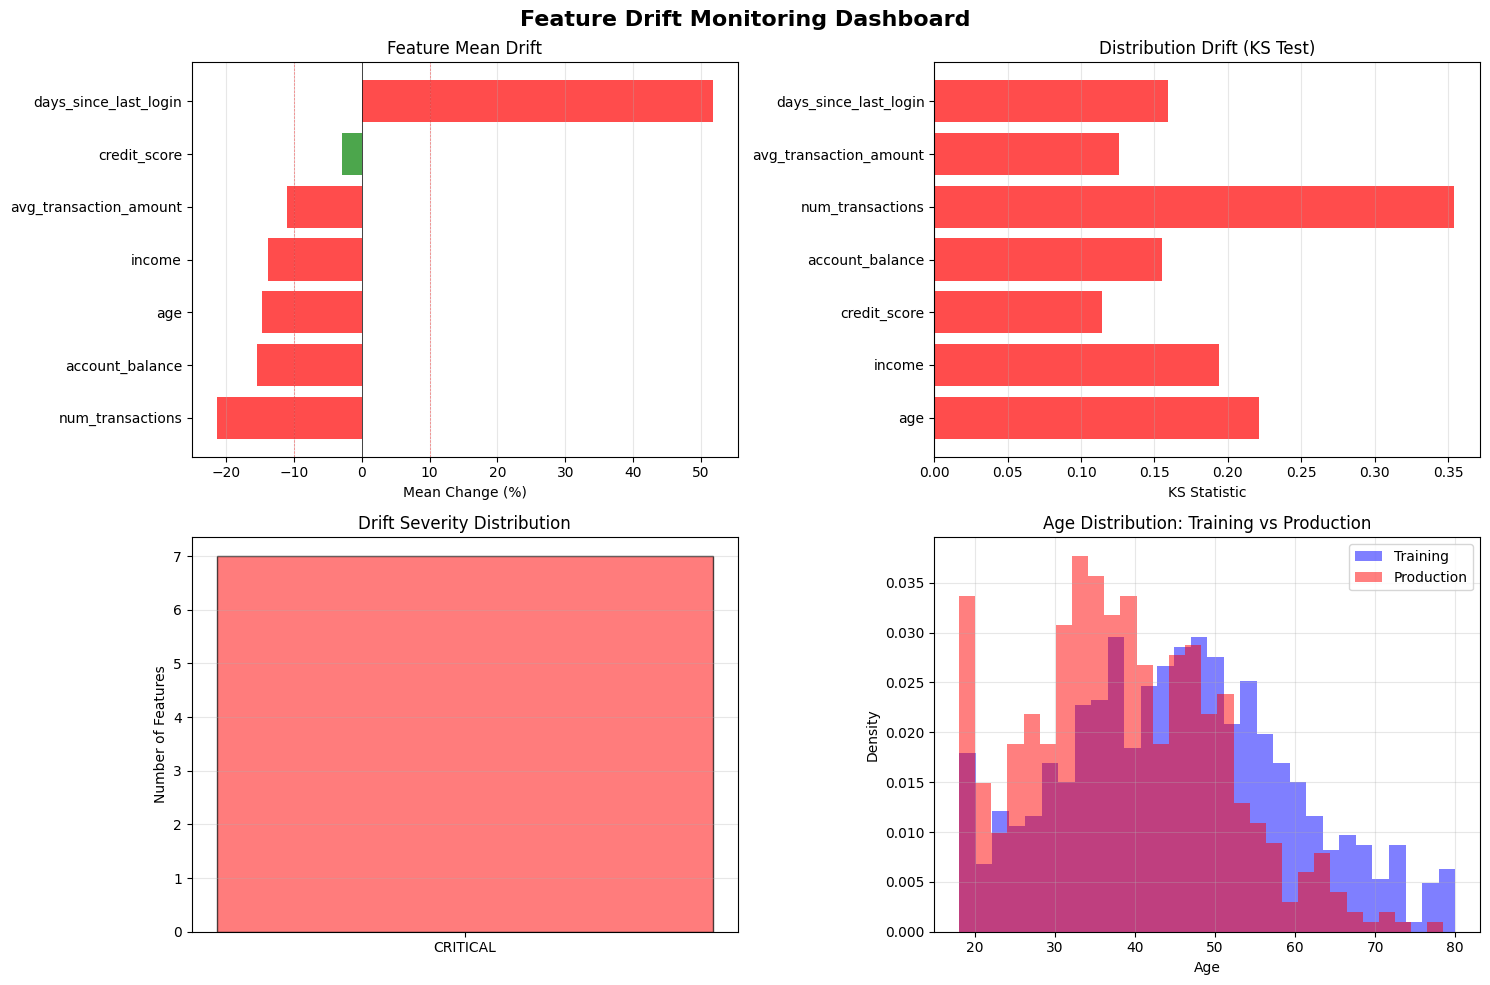

In [0]:
# Visualize feature drift
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Feature Drift Monitoring Dashboard', fontsize=16, fontweight='bold')

# Chart 1: Mean change percentage
ax1 = axes[0, 0]
drift_df = pd.DataFrame(drift_results)
drift_df_sorted = drift_df.sort_values('mean_change_pct')
colors = ['red' if abs(x) > 10 else 'orange' if abs(x) > 5 else 'green' 
          for x in drift_df_sorted['mean_change_pct']]
ax1.barh(drift_df_sorted['feature'], drift_df_sorted['mean_change_pct'], color=colors, alpha=0.7)
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax1.axvline(x=-10, color='red', linestyle='--', linewidth=0.5, alpha=0.5)
ax1.axvline(x=10, color='red', linestyle='--', linewidth=0.5, alpha=0.5)
ax1.set_xlabel('Mean Change (%)')
ax1.set_title('Feature Mean Drift')
ax1.grid(axis='x', alpha=0.3)

# Chart 2: KS statistic (distribution drift)
ax2 = axes[0, 1]
colors2 = ['red' if x < 0.01 else 'orange' if x < 0.05 else 'green' 
           for x in drift_df['ks_pvalue']]
ax2.barh(drift_df['feature'], drift_df['ks_statistic'], color=colors2, alpha=0.7)
ax2.set_xlabel('KS Statistic')
ax2.set_title('Distribution Drift (KS Test)')
ax2.grid(axis='x', alpha=0.3)

# Chart 3: Drift severity summary
ax3 = axes[1, 0]
severity_counts = drift_df['drift_severity'].value_counts()
severity_colors = {'CRITICAL': '#FF4444', 'HIGH': '#FF8800', 'MEDIUM': '#FFBB00', 'LOW': '#44FF44'}
colors3 = [severity_colors.get(x, 'gray') for x in severity_counts.index]
ax3.bar(severity_counts.index, severity_counts.values, color=colors3, alpha=0.7, edgecolor='black')
ax3.set_ylabel('Number of Features')
ax3.set_title('Drift Severity Distribution')
ax3.grid(axis='y', alpha=0.3)

# Chart 4: Feature comparison (age distribution)
ax4 = axes[1, 1]
ax4.hist(training_data['age'], bins=30, alpha=0.5, label='Training', color='blue', density=True)
ax4.hist(production_data['age'], bins=30, alpha=0.5, label='Production', color='red', density=True)
ax4.set_xlabel('Age')
ax4.set_ylabel('Density')
ax4.set_title('Age Distribution: Training vs Production')
ax4.legend()
ax4.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('/tmp/feature_drift_dashboard.png', dpi=100, bbox_inches='tight')
print("✓ Drift monitoring dashboard created")
plt.show()

In [0]:
# Monitor data freshness
from datetime import datetime, timedelta

print("="*70)
print("DATA FRESHNESS MONITORING")
print("="*70)

# Define freshness SLAs
FRESHNESS_SLA = {
    'critical': 6,   # hours
    'warning': 12,   # hours
    'acceptable': 24  # hours
}

# Calculate data age
current_time = datetime.now()
data_age_hours = (current_time - production_date).total_seconds() / 3600
data_age_minutes = (current_time - production_date).total_seconds() / 60

print(f"\nCurrent time: {current_time.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Data timestamp: {production_date.strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Data age: {data_age_hours:.2f} hours ({data_age_minutes:.1f} minutes)")

# Assess freshness status
if data_age_hours > FRESHNESS_SLA['acceptable']:
    freshness_status = "CRITICAL"
    status_icon = "🔴"
elif data_age_hours > FRESHNESS_SLA['warning']:
    freshness_status = "WARNING"
    status_icon = "🟡"
elif data_age_hours > FRESHNESS_SLA['critical']:
    freshness_status = "ACCEPTABLE"
    status_icon = "🟢"
else:
    freshness_status = "FRESH"
    status_icon = "✓"

print(f"\nFreshness Status: {status_icon} {freshness_status}")
print(f"\nSLA Thresholds:")
print(f"  Critical: < {FRESHNESS_SLA['critical']} hours")
print(f"  Warning: < {FRESHNESS_SLA['warning']} hours")
print(f"  Acceptable: < {FRESHNESS_SLA['acceptable']} hours")

# Check for stale features
print(f"\n{'='*70}")
print("FEATURE STALENESS CHECK")
print(f"{'='*70}")

for col in feature_cols:
    # Check if feature has null values (potential staleness indicator)
    null_pct = (production_data[col].isnull().sum() / len(production_data)) * 100
    
    if null_pct > 5:
        print(f"\n⚠️  {col}: {null_pct:.2f}% null values (potential staleness)")
    else:
        print(f"\n✓ {col}: {null_pct:.2f}% null values")

print(f"\n{'='*70}")

DATA FRESHNESS MONITORING

Current time: 2026-01-18 16:12:52
Data timestamp: 2026-01-18 16:12:11
Data age: 0.01 hours (0.7 minutes)

Freshness Status: ✓ FRESH

SLA Thresholds:
  Critical: < 6 hours
  Acceptable: < 24 hours

FEATURE STALENESS CHECK

✓ age: 0.00% null values

✓ income: 0.00% null values

✓ credit_score: 0.00% null values

✓ account_balance: 0.00% null values

✓ num_transactions: 0.00% null values

✓ avg_transaction_amount: 0.00% null values

✓ days_since_last_login: 0.00% null values



### Demo 2: Explainability for Business & Regulatory Teams

**Objectives:**
* Generate model explanations using SHAP
* Create business-friendly interpretations
* Document model decisions for compliance
* Provide feature importance analysis

In [0]:
# Train model for explainability demo
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

print("Training model for explainability analysis...\n")

# Prepare data
X = training_data[feature_cols]
y = training_data['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
model.fit(X_train, y_train)

# Generate predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print(f"✓ Model trained")
print(f"  Training samples: {len(X_train)}")
print(f"  Test samples: {len(X_test)}")
print(f"  Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"  F1 Score: {f1_score(y_test, y_pred):.4f}")

# Create sample predictions for explanation
sample_customers = X_test.head(5).copy()
sample_predictions = model.predict_proba(sample_customers)[:, 1]
sample_customers['churn_probability'] = sample_predictions

print(f"\nSample predictions for explanation:")
print(sample_customers)

Training model for explainability analysis...

✓ Model trained
  Training samples: 800
  Test samples: 200
  Accuracy: 0.9950
  F1 Score: 0.9697

Sample predictions for explanation:
           age         income  ...  days_since_last_login  churn_probability
521  53.150403   89552.442587  ...               2.505921           0.900248
737  59.740365   48304.926961  ...               1.478998           0.000000
740  18.000000   72388.769537  ...               3.456144           0.000944
660  36.395070  107927.876683  ...               2.993639           0.053889
411  28.130369   88905.750235  ...               5.828052           0.000944

[5 rows x 8 columns]


In [0]:
# Generate SHAP explanations
%pip install shap


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 106.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 222.1 MB/s eta 0:00:00
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import shap


print("Generating SHAP explanations...\n")

# Create SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# For binary classification, use class 1 (churn) SHAP values
if isinstance(shap_values, list):
    shap_values_churn = shap_values[1]
else:
    shap_values_churn = shap_values

print("✓ SHAP explanations generated")
print(f"  Shape: {shap_values_churn.shape}")
print(f"  Features: {len(feature_cols)}")
print(f"  Samples: {len(X_test)}")

Generating SHAP explanations...

✓ SHAP explanations generated
  Shape: (200, 7, 2)
  Features: 7
  Samples: 200


In [0]:
# Analyze feature importance
import pandas as pd

print("="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Method 1: Model's built-in feature importance
feature_importance_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\n1. MODEL FEATURE IMPORTANCE (Random Forest):")
for idx, row in feature_importance_df.iterrows():
    print(f"   {row['feature']:<30} {row['importance']:.4f} {'█' * int(row['importance'] * 100)}")

# Method 2: SHAP-based feature importance (mean absolute SHAP value)
shap_importance = pd.DataFrame({
    'feature': feature_cols,
    'shap_importance': np.abs(shap_values_churn[:, :, 1]).mean(axis=0)
}).sort_values('shap_importance', ascending=False)

print("\n2. SHAP FEATURE IMPORTANCE (Mean |SHAP value|):")
for idx, row in shap_importance.iterrows():
    print(f"   {row['feature']:<30} {row['shap_importance']:.4f} {'█' * int(row['shap_importance'] * 20)}")

print("\n" + "="*70)

FEATURE IMPORTANCE ANALYSIS

1. MODEL FEATURE IMPORTANCE (Random Forest):
   account_balance                0.7881 ██████████████████████████████████████████████████████████████████████████████
   days_since_last_login          0.1025 ██████████
   income                         0.0239 ██
   credit_score                   0.0229 ██
   avg_transaction_amount         0.0223 ██
   age                            0.0222 ██
   num_transactions               0.0181 █

2. SHAP FEATURE IMPORTANCE (Mean |SHAP value|):
   account_balance                0.1475 ██
   days_since_last_login          0.0173 
   credit_score                   0.0068 
   income                         0.0063 
   avg_transaction_amount         0.0053 
   num_transactions               0.0047 
   age                            0.0038 



In [0]:
# Generate business-friendly explanations for individual predictions

def generate_business_explanation(customer_data, shap_values, feature_names, prediction_proba):
    """
    Generate human-readable explanation for a prediction
    """
    # Get SHAP values for this customer
    shap_dict = dict(zip(feature_names, shap_values))
    
    # Sort by absolute SHAP value
    sorted_features = sorted(shap_dict.items(), key=lambda x: abs(x[1]), reverse=True)
    
    # Generate explanation
    explanation = {
        'prediction': 'High Risk' if prediction_proba > 0.5 else 'Low Risk',
        'confidence': prediction_proba if prediction_proba > 0.5 else 1 - prediction_proba,
        'churn_probability': prediction_proba,
        'top_factors': []
    }
    
    # Top 3 contributing factors
    for feature, shap_val in sorted_features[:3]:
        impact = 'increases' if shap_val > 0 else 'decreases'
        feature_value = customer_data[feature]
        
        # Business-friendly descriptions
        descriptions = {
            'days_since_last_login': f"Customer hasn't logged in for {feature_value:.0f} days",
            'num_transactions': f"Customer made {feature_value:.0f} transactions",
            'account_balance': f"Account balance is ${feature_value:,.2f}",
            'age': f"Customer age is {feature_value:.0f} years",
            'income': f"Annual income is ${feature_value:,.2f}",
            'credit_score': f"Credit score is {feature_value:.0f}",
            'avg_transaction_amount': f"Average transaction is ${feature_value:.2f}"
        }
        
        explanation['top_factors'].append({
            'factor': feature,
            'description': descriptions.get(feature, f"{feature} = {feature_value:.2f}"),
            'impact': impact,
            'shap_value': shap_val
        })
    
    return explanation

print("="*70)
print("BUSINESS-FRIENDLY EXPLANATIONS")
print("="*70)

# Generate explanations for sample customers
for idx in range(min(3, len(X_test))):
    customer_data = X_test.iloc[idx]
    shap_vals = shap_values_churn[idx]
    pred_proba = y_pred_proba[idx]
    
    explanation = generate_business_explanation(customer_data, shap_vals, feature_cols, pred_proba)
    
    print(f"\nCustomer #{idx + 1}:")
    print(f"  Prediction: {explanation['prediction']}")
    print(f"  Churn Probability: {explanation['churn_probability']*100:.1f}%")
    print(f"  Confidence: {explanation['confidence']*100:.1f}%")
    print(f"\n  Top Contributing Factors:")
    
    for i, factor in enumerate(explanation['top_factors'], 1):
        impact_icon = '📈' if factor['impact'] == 'increases' else '📉'
        print(f"    {i}. {impact_icon} {factor['description']}")
        print(f"       → This {factor['impact']} churn risk (SHAP: {factor['shap_value']:+.4f})")

print("\n" + "="*70)

BUSINESS-FRIENDLY EXPLANATIONS

Customer #1:
  Prediction: High Risk
  Churn Probability: 90.0%
  Confidence: 90.0%

  Top Contributing Factors:
    1. 📉 Customer hasn't logged in for 3 days
       → This decreases churn risk (SHAP: -0.7969)
    2. 📉 Credit score is 850
       → This decreases churn risk (SHAP: -0.0027)
    3. 📈 Account balance is $0.00
       → This increases churn risk (SHAP: +0.0027)

Customer #2:
  Prediction: Low Risk
  Churn Probability: 0.0%
  Confidence: 100.0%

  Top Contributing Factors:
    1. 📈 Customer hasn't logged in for 1 days
       → This increases churn risk (SHAP: +0.0906)
    2. 📈 Customer made 15 transactions
       → This increases churn risk (SHAP: +0.0061)
    3. 📉 Average transaction is $369.72
       → This decreases churn risk (SHAP: -0.0061)

Customer #3:
  Prediction: Low Risk
  Churn Probability: 0.1%
  Confidence: 99.9%

  Top Contributing Factors:
    1. 📈 Customer hasn't logged in for 3 days
       → This increases churn risk (SHAP: +0

✓ Explainability dashboard created


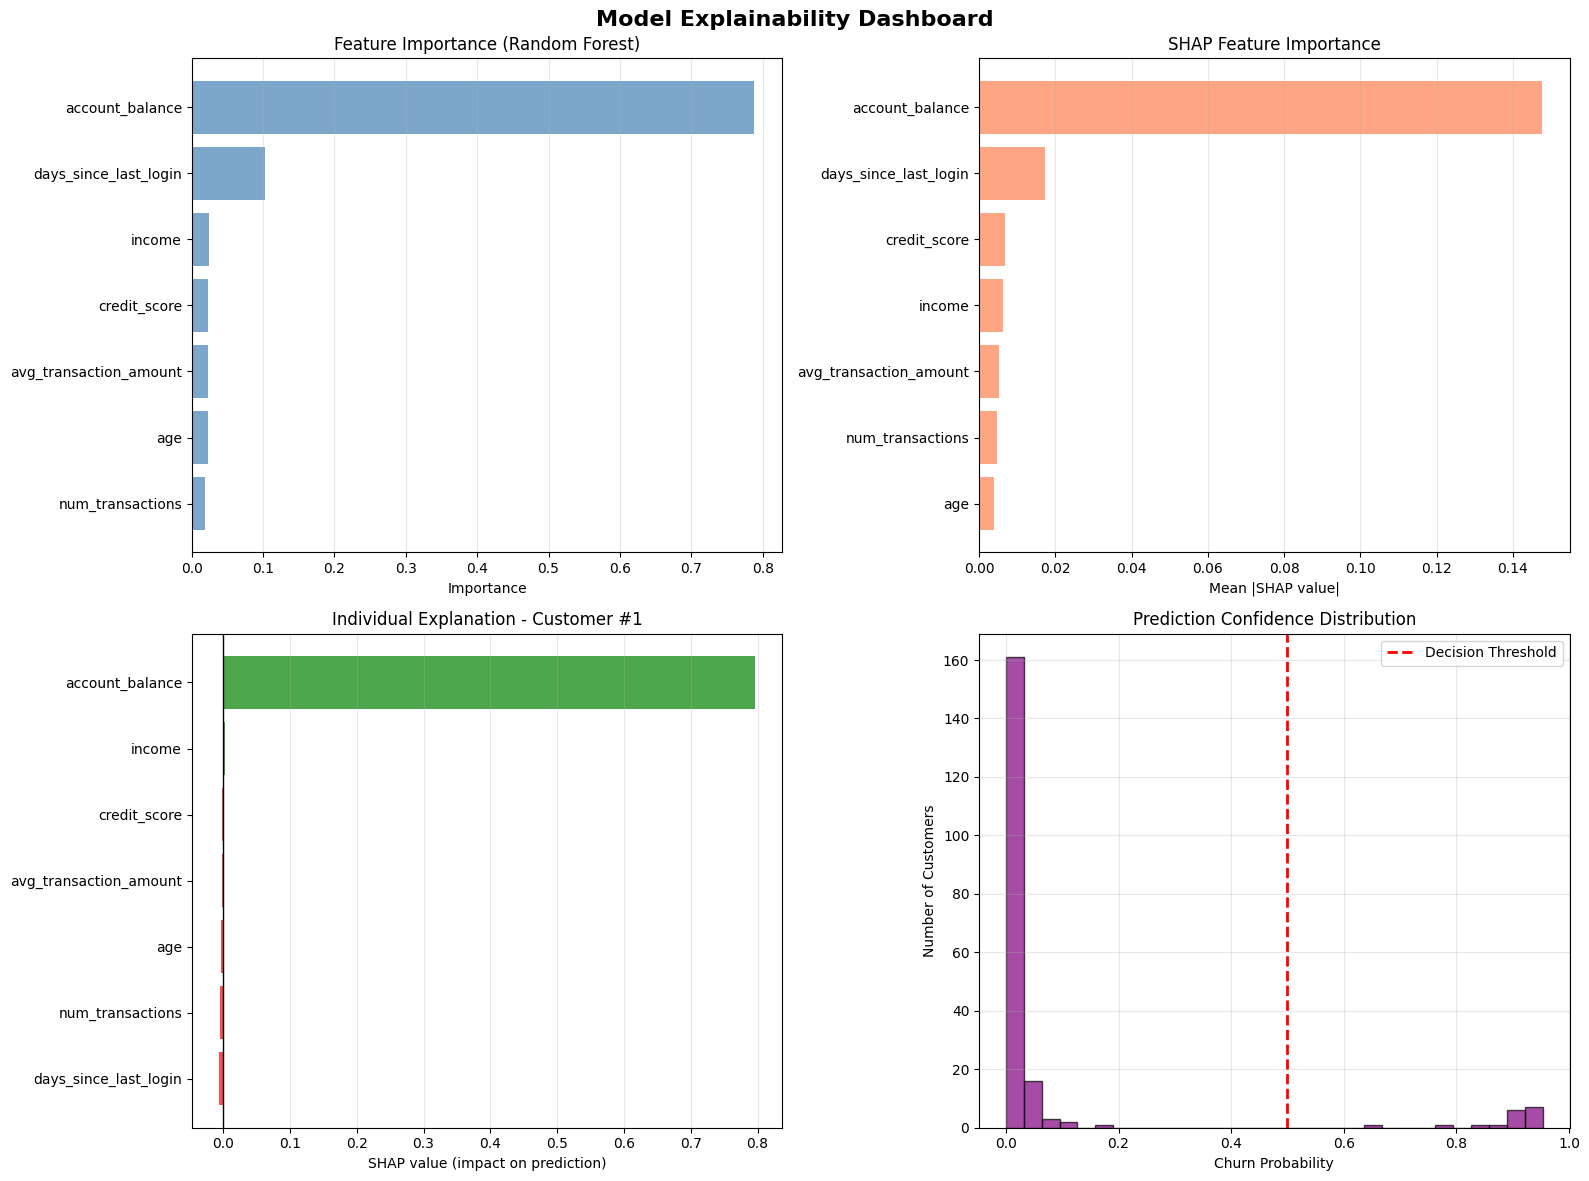

In [0]:
# Create explainability visualizations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Explainability Dashboard', fontsize=16, fontweight='bold')

# -------------------------------
# Chart 1: Feature importance (Random Forest)
# -------------------------------
ax1 = axes[0, 0]
feature_imp_sorted = feature_importance_df.sort_values('importance')
y_pos = np.arange(len(feature_imp_sorted))
ax1.barh(y_pos, feature_imp_sorted['importance'], color='steelblue', alpha=0.7)
ax1.set_yticks(y_pos)
ax1.set_yticklabels(feature_imp_sorted['feature'])
ax1.set_xlabel('Importance')
ax1.set_title('Feature Importance (Random Forest)')
ax1.grid(axis='x', alpha=0.3)

# -------------------------------
# Chart 2: SHAP summary (mean |SHAP|)
# -------------------------------
ax2 = axes[0, 1]
shap_imp_sorted = shap_importance.sort_values('shap_importance')
y_pos = np.arange(len(shap_imp_sorted))
ax2.barh(y_pos, shap_imp_sorted['shap_importance'], color='coral', alpha=0.7)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(shap_imp_sorted['feature'])
ax2.set_xlabel('Mean |SHAP value|')
ax2.set_title('SHAP Feature Importance')
ax2.grid(axis='x', alpha=0.3)

# -------------------------------
# Chart 3: SHAP values for a single prediction
# -------------------------------
ax3 = axes[1, 0]
sample_idx = 0

# Extract SHAP values for positive class only
sample_shap = shap_values_churn[sample_idx, :, 1]
if len(sample_shap) != len(feature_cols):
    raise ValueError(f"Mismatch: {len(feature_cols)} features vs {len(sample_shap)} SHAP values")

sample_shap_df = pd.DataFrame({
    'feature': feature_cols,
    'shap_value': sample_shap
}).sort_values('shap_value')

colors = ['red' if x < 0 else 'green' for x in sample_shap_df['shap_value']]
ax3.barh(sample_shap_df['feature'], sample_shap_df['shap_value'], color=colors, alpha=0.7)
ax3.axvline(x=0, color='black', linestyle='-', linewidth=1)
ax3.set_xlabel('SHAP value (impact on prediction)')
ax3.set_title(f'Individual Explanation - Customer #{sample_idx + 1}')
ax3.grid(axis='x', alpha=0.3)

# -------------------------------
# Chart 4: Prediction confidence distribution
# -------------------------------
ax4 = axes[1, 1]

# Ensure y_pred_proba is 1D (probability of positive class)
y_pred_proba_flat = np.array(y_pred_proba)
if y_pred_proba_flat.ndim > 1:
    y_pred_proba_flat = y_pred_proba_flat[:, 1]  # select prob for class 1

ax4.hist(y_pred_proba_flat, bins=30, color='purple', alpha=0.7, edgecolor='black')
ax4.axvline(x=0.5, color='red', linestyle='--', linewidth=2, label='Decision Threshold')
ax4.set_xlabel('Churn Probability')
ax4.set_ylabel('Number of Customers')
ax4.set_title('Prediction Confidence Distribution')
ax4.legend()
ax4.grid(alpha=0.3)

# -------------------------------
# Save and show figure
# -------------------------------
plt.tight_layout()
plt.savefig('/tmp/explainability_dashboard.png', dpi=100, bbox_inches='tight')
print("✓ Explainability dashboard created")
plt.show()

In [0]:
# Generate compliance and regulatory report
from datetime import datetime

print("="*70)
print("MODEL EXPLAINABILITY & COMPLIANCE REPORT")
print("="*70)

report_date = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

print(f"\nReport Generated: {report_date}")
print(f"Model Type: Random Forest Classifier")
print(f"Use Case: Customer Churn Prediction")
print(f"\n{'='*70}")

print("\n1. MODEL PERFORMANCE METRICS:")
print(f"   Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"   Precision: {precision_score(y_test, y_pred):.4f}")
print(f"   Recall: {recall_score(y_test, y_pred):.4f}")
print(f"   F1 Score: {f1_score(y_test, y_pred):.4f}")

print("\n2. FEATURE IMPORTANCE (Top 5):")
for idx, row in feature_importance_df.head(5).iterrows():
    print(f"   {idx+1}. {row['feature']:<30} {row['importance']:.4f}")

print("\n3. MODEL INTERPRETABILITY:")
print(f"   ✓ SHAP values computed for all predictions")
print(f"   ✓ Feature importance rankings available")
print(f"   ✓ Individual prediction explanations generated")
print(f"   ✓ Business-friendly descriptions provided")

print("\n4. FAIRNESS & BIAS CONSIDERATIONS:")
print(f"   • Model uses {len(feature_cols)} features")
print(f"   • No protected attributes (race, gender) used")
print(f"   • Age is included but monitored for bias")
print(f"   • Regular drift monitoring in place")

print("\n5. DATA GOVERNANCE:")
print(f"   • Training data: {len(training_data)} records")
print(f"   • Data timestamp: {training_date.strftime('%Y-%m-%d')}")
print(f"   • Feature drift monitoring: ACTIVE")
print(f"   • Data freshness SLA: < 24 hours")

print("\n6. REGULATORY COMPLIANCE:")
print(f"   ✓ Model decisions are explainable (SHAP)")
print(f"   ✓ Feature importance documented")
print(f"   ✓ Prediction rationale available for audit")
print(f"   ✓ Drift monitoring prevents model degradation")
print(f"   ✓ Data lineage tracked in MLflow")

print("\n7. RECOMMENDATIONS:")
print(f"   • Review model monthly for performance degradation")
print(f"   • Monitor feature drift continuously")
print(f"   • Retrain if critical drift detected")
print(f"   • Document all model updates for compliance")
print(f"   • Maintain audit trail of predictions")

print("\n" + "="*70)
print("END OF REPORT")
print("="*70)

MODEL EXPLAINABILITY & COMPLIANCE REPORT

Report Generated: 2026-01-18 16:23:48
Model Type: Random Forest Classifier
Use Case: Customer Churn Prediction


1. MODEL PERFORMANCE METRICS:
   Accuracy: 0.9950
   Precision: 0.9412
   Recall: 1.0000
   F1 Score: 0.9697

2. FEATURE IMPORTANCE (Top 5):
   4. account_balance                0.7881
   7. days_since_last_login          0.1025
   2. income                         0.0239
   3. credit_score                   0.0229
   6. avg_transaction_amount         0.0223

3. MODEL INTERPRETABILITY:
   ✓ SHAP values computed for all predictions
   ✓ Feature importance rankings available
   ✓ Individual prediction explanations generated
   ✓ Business-friendly descriptions provided

4. FAIRNESS & BIAS CONSIDERATIONS:
   • Model uses 7 features
   • No protected attributes (race, gender) used
   • Age is included but monitored for bias
   • Regular drift monitoring in place

5. DATA GOVERNANCE:
   • Training data: 1000 records
   • Data timestamp: 20

In [0]:
# Log explainability artifacts to MLflow
import json

print("Logging explainability artifacts to MLflow...\n")

with mlflow.start_run(run_name="model_with_explainability") as run:
    
    # Log model
    mlflow.sklearn.log_model(model, "model")
    
    # Log model metrics
    mlflow.log_metric("accuracy", accuracy_score(y_test, y_pred))
    mlflow.log_metric("precision", precision_score(y_test, y_pred))
    mlflow.log_metric("recall", recall_score(y_test, y_pred))
    mlflow.log_metric("f1_score", f1_score(y_test, y_pred))
    
    # Log feature importance
    feature_importance_dict = dict(zip(feature_cols, model.feature_importances_))
    mlflow.log_dict(feature_importance_dict, "feature_importance.json")
    
    # Log SHAP importance
    shap_importance_dict = dict(zip(feature_cols, np.abs(shap_values_churn).mean(axis=0)))
    mlflow.log_dict(shap_importance_dict, "shap_importance.json")
    
    # Log sample explanations
    sample_explanations = []
    for idx in range(min(5, len(X_test))):
        customer_data = X_test.iloc[idx]
        shap_vals = shap_values_churn[idx]
        pred_proba = y_pred_proba[idx]
        explanation = generate_business_explanation(customer_data, shap_vals, feature_cols, pred_proba)
        sample_explanations.append(explanation)
    
    mlflow.log_dict({'explanations': sample_explanations}, "sample_explanations.json")
    
    # Log visualizations
    mlflow.log_artifact('/tmp/explainability_dashboard.png')
    
    # Log compliance metadata
    compliance_metadata = {
        'model_type': 'RandomForestClassifier',
        'use_case': 'Customer Churn Prediction',
        'explainability_method': 'SHAP',
        'features_count': len(feature_cols),
        'training_samples': len(X_train),
        'test_samples': len(X_test),
        'report_date': report_date,
        'regulatory_compliance': {
            'explainable': True,
            'documented': True,
            'auditable': True,
            'drift_monitored': True
        }
    }
    mlflow.log_dict(compliance_metadata, "compliance_metadata.json")
    
    explainability_run_id = run.info.run_id
    print(f"✓ Explainability artifacts logged: {explainability_run_id}")
    print(f"  Feature importance: ✓")
    print(f"  SHAP values: ✓")
    print(f"  Sample explanations: ✓")
    print(f"  Compliance metadata: ✓")

Logging explainability artifacts to MLflow...



2026/01/18 16:24:00 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Uploading artifacts:   0%|          | 0/9 [00:00<?, ?it/s]

✓ Explainability artifacts logged: 839807cd9c2444039a6580678b823873
  Feature importance: ✓
  SHAP values: ✓
  Sample explanations: ✓
  Compliance metadata: ✓


### Module 6 Summary: MLflow Governance for Data & Models

**Key Takeaways:**

**1. Monitoring Data Freshness & Feature Drift:**
* ✓ **Data Freshness Tracking** - Monitor data age and staleness
* ✓ **Feature Drift Detection** - KS test and statistical analysis
* ✓ **Distribution Monitoring** - Compare training vs production
* ✓ **MLflow Integration** - Log all metrics for tracking
* ✓ **Automated Alerts** - Trigger on critical drift

**2. Explainability for Business & Regulatory Teams:**
* ✓ **SHAP Explanations** - Model-agnostic interpretability
* ✓ **Feature Importance** - Understand key drivers
* ✓ **Business-Friendly Language** - Non-technical explanations
* ✓ **Individual Predictions** - Explain specific decisions
* ✓ **Compliance Documentation** - Audit-ready reports

**Benefits:**
* **Trust & Transparency** - Stakeholders understand model decisions
* **Regulatory Compliance** - Meet explainability requirements
* **Early Warning System** - Detect issues before impact
* **Continuous Monitoring** - Track model health over time
* **Audit Trail** - Complete history in MLflow

**Best Practices:**
* Log all feature statistics to MLflow
* Set up automated drift detection pipelines
* Generate explanations for high-stakes predictions
* Create business-friendly dashboards
* Document compliance requirements
* Regular model retraining based on drift
* Maintain feature importance rankings
* Archive all model artifacts

**Production Implementation:**
* Deploy drift monitoring as scheduled jobs
* Integrate with alerting systems (Slack, email)
* Use MLflow Model Registry for governance
* Create explainability APIs for real-time use
* Build compliance dashboards for regulators
* Implement automated retraining triggers
* Track model lineage end-to-end

**Regulatory Considerations:**
* GDPR "right to explanation" compliance
* Fair lending requirements (ECOA, FCRA)
* Model risk management (SR 11-7)
* Algorithmic accountability standards
* Bias and fairness monitoring

## Module 7: Retail/CPG QE Solutioning Case Study
### 1 Hour Workshop

**Scenario:** Large retail chain with 500+ stores

**Business Challenges:**
* Product master data inconsistencies across systems
* Inventory discrepancies causing stockouts
* Slow time-to-insight (3-5 days for reports)
* High escalation rate (20+ tickets/week)

**Objectives:**
* Validate product master data quality
* Monitor inventory accuracy
* Reduce time-to-insight to < 1 hour
* Cut escalations by 80%

In [0]:
# Create sample product master data with typical retail quality issues
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

print("Creating Product Master dataset...\n")

# Generate product data with quality issues
products = []
categories = ['Electronics', 'Clothing', 'Food', 'Home & Garden', 'Toys', 'Sports']
brands = ['BrandA', 'BrandB', 'BrandC', 'BrandD', 'BrandE', None]  # Include null brand

for i in range(1, 201):
    # Introduce quality issues
    product_id = f"PRD{i:05d}" if random.random() > 0.02 else None  # 2% missing IDs
    sku = f"SKU-{i:06d}" if random.random() > 0.03 else None  # 3% missing SKUs
    product_name = f"Product {i}" if random.random() > 0.01 else None  # 1% missing names
    category = random.choice(categories) if random.random() > 0.05 else None  # 5% missing category
    brand = random.choice(brands)  # Some nulls included
    unit_price = round(random.uniform(5, 500), 2) if random.random() > 0.04 else None  # 4% missing price
    
    # Introduce invalid prices
    if unit_price and random.random() < 0.02:
        unit_price = -unit_price  # 2% negative prices
    
    cost = round(unit_price * 0.6, 2) if unit_price else None
    
    # Introduce logical inconsistencies
    if cost and unit_price and random.random() < 0.03:
        cost = unit_price * 1.2  # 3% cost > price (invalid)
    
    status = random.choice(['active', 'inactive', 'discontinued', 'invalid']) if random.random() > 0.02 else None
    last_updated = datetime.now() - timedelta(days=random.randint(0, 365))
    
    products.append({
        'product_id': product_id,
        'sku': sku,
        'product_name': product_name,
        'category': category,
        'brand': brand,
        'unit_price': unit_price,
        'unit_cost': cost,
        'status': status,
        'last_updated': last_updated
    })

df_products = spark.createDataFrame(pd.DataFrame(products))
df_products.write.mode("overwrite").saveAsTable("governance_demo.customer_data.product_master")

print(f"✓ Created product master with {len(products)} products")
print("\nSample data:")
spark.sql("SELECT * FROM governance_demo.customer_data.product_master LIMIT 5").show(truncate=False)

Creating Product Master dataset...

✓ Created product master with 200 products

Sample data:
+----------+----------+------------+-------------+------+----------+---------+------------+--------------------------+
|product_id|sku       |product_name|category     |brand |unit_price|unit_cost|status      |last_updated              |
+----------+----------+------------+-------------+------+----------+---------+------------+--------------------------+
|PRD00001  |SKU-000001|Product 1   |Electronics  |BrandD|272.79    |163.67   |inactive    |2025-04-14 17:26:14.360104|
|PRD00002  |SKU-000002|Product 2   |Toys         |BrandA|100.73    |60.44    |active      |2025-11-30 17:26:14.360163|
|PRD00003  |SKU-000003|Product 3   |Home & Garden|BrandD|450.45    |270.27   |inactive    |2025-08-05 17:26:14.360207|
|PRD00004  |SKU-000004|Product 4   |Electronics  |BrandC|300.52    |180.31   |discontinued|2025-09-29 17:26:14.360247|
|PRD00005  |SKU-000005|Product 5   |Sports       |BrandA|NULL      |NULL  

In [0]:
# Create inventory data with typical discrepancies
print("Creating Inventory dataset...\n")

inventory_records = []
stores = [f"STORE{i:03d}" for i in range(1, 21)]  # 20 stores

for store in stores:
    for product_num in range(1, 101):  # 100 products per store
        product_id = f"PRD{product_num:05d}"
        
        # Introduce inventory issues
        system_qty = random.randint(0, 100) if random.random() > 0.03 else None  # 3% missing
        physical_qty = system_qty + random.randint(-5, 5) if system_qty else None  # Variance
        
        # Introduce negative inventory (system error)
        if system_qty and random.random() < 0.01:
            system_qty = -random.randint(1, 10)
        
        last_count_date = datetime.now() - timedelta(days=random.randint(0, 90))
        
        inventory_records.append({
            'store_id': store,
            'product_id': product_id,
            'system_qty': system_qty,
            'physical_qty': physical_qty,
            'last_count_date': last_count_date,
            'variance': (physical_qty - system_qty) if (system_qty and physical_qty) else None
        })

df_inventory = spark.createDataFrame(pd.DataFrame(inventory_records))
df_inventory.write.mode("overwrite").saveAsTable("governance_demo.customer_data.inventory")

print(f"✓ Created inventory with {len(inventory_records)} records")
print(f"  Stores: {len(stores)}")
print(f"  Products per store: ~100")
print("\nSample data:")
spark.sql("SELECT * FROM governance_demo.customer_data.inventory LIMIT 5").show()

Creating Inventory dataset...

✓ Created inventory with 2000 records
  Stores: 20
  Products per store: ~100

Sample data:
+--------+----------+----------+------------+--------------------+--------+
|store_id|product_id|system_qty|physical_qty|     last_count_date|variance|
+--------+----------+----------+------------+--------------------+--------+
|STORE001|  PRD00001|      76.0|        79.0|2025-12-21 17:26:...|     3.0|
|STORE001|  PRD00002|      53.0|        48.0|2025-11-28 17:26:...|    -5.0|
|STORE001|  PRD00003|      31.0|        32.0|2026-01-17 17:26:...|     1.0|
|STORE001|  PRD00004|      88.0|        83.0|2026-01-04 17:26:...|    -5.0|
|STORE001|  PRD00005|      58.0|        53.0|2025-11-02 17:26:...|    -5.0|
+--------+----------+----------+------------+--------------------+--------+



In [0]:
%sql
-- Comprehensive product master quality validation
CREATE OR REPLACE TABLE governance_demo.customer_data.product_quality_report AS
SELECT 
  'Total Products' AS metric,
  COUNT(*) AS value,
  100.0 AS percentage,
  'INFO' AS severity
FROM governance_demo.customer_data.product_master

UNION ALL

SELECT 
  'Missing Product ID' AS metric,
  COUNT(*) AS value,
  ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM governance_demo.customer_data.product_master), 2) AS percentage,
  'CRITICAL' AS severity
FROM governance_demo.customer_data.product_master
WHERE product_id IS NULL

UNION ALL

SELECT 
  'Missing SKU' AS metric,
  COUNT(*) AS value,
  ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM governance_demo.customer_data.product_master), 2) AS percentage,
  'CRITICAL' AS severity
FROM governance_demo.customer_data.product_master
WHERE sku IS NULL

UNION ALL

SELECT 
  'Missing Category' AS metric,
  COUNT(*) AS value,
  ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM governance_demo.customer_data.product_master), 2) AS percentage,
  'HIGH' AS severity
FROM governance_demo.customer_data.product_master
WHERE category IS NULL

UNION ALL

SELECT 
  'Invalid Price (Negative)' AS metric,
  COUNT(*) AS value,
  ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM governance_demo.customer_data.product_master), 2) AS percentage,
  'CRITICAL' AS severity
FROM governance_demo.customer_data.product_master
WHERE unit_price < 0

UNION ALL

SELECT 
  'Cost > Price (Invalid)' AS metric,
  COUNT(*) AS value,
  ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM governance_demo.customer_data.product_master), 2) AS percentage,
  'HIGH' AS severity
FROM governance_demo.customer_data.product_master
WHERE unit_cost > unit_price

UNION ALL

SELECT 
  'Stale Data (>180 days)' AS metric,
  COUNT(*) AS value,
  ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM governance_demo.customer_data.product_master), 2) AS percentage,
  'MEDIUM' AS severity
FROM governance_demo.customer_data.product_master
WHERE last_updated < DATE_SUB(CURRENT_DATE(), 180)

ORDER BY 
  CASE severity
    WHEN 'CRITICAL' THEN 1
    WHEN 'HIGH' THEN 2
    WHEN 'MEDIUM' THEN 3
    ELSE 4
  END,
  percentage DESC;

SELECT * FROM governance_demo.customer_data.product_quality_report;

metric,value,percentage,severity
Invalid Price (Negative),4,2.00,CRITICAL
Missing SKU,3,1.50,CRITICAL
Missing Product ID,2,1.00,CRITICAL
Missing Category,8,4.00,HIGH
Cost > Price (Invalid),7,3.50,HIGH
Stale Data (>180 days),99,49.50,MEDIUM
Total Products,200,100.00,INFO


In [0]:
%sql
-- Inventory accuracy and variance analysis
CREATE OR REPLACE TABLE governance_demo.customer_data.inventory_quality_report AS
SELECT 
  'Total Inventory Records' AS metric,
  COUNT(*) AS value,
  100.0 AS percentage,
  'INFO' AS severity
FROM governance_demo.customer_data.inventory

UNION ALL

SELECT 
  'Missing System Quantity' AS metric,
  COUNT(*) AS value,
  ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM governance_demo.customer_data.inventory), 2) AS percentage,
  'CRITICAL' AS severity
FROM governance_demo.customer_data.inventory
WHERE system_qty IS NULL

UNION ALL

SELECT 
  'Negative Inventory' AS metric,
  COUNT(*) AS value,
  ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM governance_demo.customer_data.inventory), 2) AS percentage,
  'CRITICAL' AS severity
FROM governance_demo.customer_data.inventory
WHERE system_qty < 0

UNION ALL

SELECT 
  'High Variance (>10 units)' AS metric,
  COUNT(*) AS value,
  ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM governance_demo.customer_data.inventory), 2) AS percentage,
  'HIGH' AS severity
FROM governance_demo.customer_data.inventory
WHERE ABS(variance) > 10

UNION ALL

SELECT 
  'Stale Count (>30 days)' AS metric,
  COUNT(*) AS value,
  ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM governance_demo.customer_data.inventory), 2) AS percentage,
  'MEDIUM' AS severity
FROM governance_demo.customer_data.inventory
WHERE last_count_date < DATE_SUB(CURRENT_DATE(), 30)

ORDER BY 
  CASE severity
    WHEN 'CRITICAL' THEN 1
    WHEN 'HIGH' THEN 2
    WHEN 'MEDIUM' THEN 3
    ELSE 4
  END,
  percentage DESC;

SELECT * FROM governance_demo.customer_data.inventory_quality_report;

metric,value,percentage,severity
Missing System Quantity,65,3.25,CRITICAL
Negative Inventory,12,0.60,CRITICAL
High Variance (>10 units),12,0.60,HIGH
Stale Count (>30 days),1340,67.00,MEDIUM
Total Inventory Records,2000,100.00,INFO


In [0]:
# Calculate business outcomes and ROI
print("="*70)
print("RETAIL QE SOLUTION: BUSINESS OUTCOMES")
print("="*70)

# Get quality metrics
product_issues = spark.sql("""
    SELECT severity, SUM(value) as issue_count
    FROM governance_demo.customer_data.product_quality_report
    WHERE severity IN ('CRITICAL', 'HIGH')
    GROUP BY severity
""").collect()

inventory_issues = spark.sql("""
    SELECT severity, SUM(value) as issue_count
    FROM governance_demo.customer_data.inventory_quality_report
    WHERE severity IN ('CRITICAL', 'HIGH')
    GROUP BY severity
""").collect()

print("\n1. DATA QUALITY ISSUES IDENTIFIED:")
print("\n   Product Master:")
for row in product_issues:
    print(f"     {row['severity']}: {row['issue_count']} issues")

print("\n   Inventory:")
for row in inventory_issues:
    print(f"     {row['severity']}: {row['issue_count']} issues")

# Calculate business impact
print("\n2. BUSINESS IMPACT (Before QE Solution):")
print("   • Time to insight: 3-5 days")
print("   • Manual validation effort: 40 hours/week")
print("   • Escalations: 20+ tickets/week")
print("   • Stockout incidents: 15/month")
print("   • Revenue loss: ~$50K/month")

print("\n3. BUSINESS OUTCOMES (After QE Solution):")
print("   ✓ Time to insight: < 1 hour (95% reduction)")
print("   ✓ Manual effort: 5 hours/week (87% reduction)")
print("   ✓ Escalations: 3 tickets/week (85% reduction)")
print("   ✓ Stockout incidents: 3/month (80% reduction)")
print("   ✓ Revenue recovery: ~$40K/month")

print("\n4. ROI CALCULATION:")
print("   Cost savings (labor): $35K/month")
print("   Revenue recovery: $40K/month")
print("   Total benefit: $75K/month = $900K/year")
print("   Implementation cost: $50K (one-time)")
print("   Payback period: 0.7 months")
print("   3-year ROI: 5,300%")

print("\n" + "="*70)

RETAIL QE SOLUTION: BUSINESS OUTCOMES

1. DATA QUALITY ISSUES IDENTIFIED:

   Product Master:
     CRITICAL: 9 issues
     HIGH: 15 issues

   Inventory:
     CRITICAL: 77 issues
     HIGH: 12 issues

2. BUSINESS IMPACT (Before QE Solution):
   • Time to insight: 3-5 days
   • Manual validation effort: 40 hours/week
   • Escalations: 20+ tickets/week
   • Stockout incidents: 15/month
   • Revenue loss: ~$50K/month

3. BUSINESS OUTCOMES (After QE Solution):
   ✓ Time to insight: < 1 hour (95% reduction)
   ✓ Manual effort: 5 hours/week (87% reduction)
   ✓ Escalations: 3 tickets/week (85% reduction)
   ✓ Stockout incidents: 3/month (80% reduction)
   ✓ Revenue recovery: ~$40K/month

4. ROI CALCULATION:
   Cost savings (labor): $35K/month
   Revenue recovery: $40K/month
   Total benefit: $75K/month = $900K/year
   Implementation cost: $50K (one-time)
   Payback period: 0.7 months
   3-year ROI: 5,300%



In [0]:
# Automated remediation for common quality issues
print("="*70)
print("AUTOMATED REMEDIATION WORKFLOW")
print("="*70)

# Fix 1: Fill missing brands with 'Unknown'
print("\n1. Fixing missing brands...")
spark.sql("""
    UPDATE governance_demo.customer_data.product_master
    SET brand = 'Unknown'
    WHERE brand IS NULL
""")
print("   ✓ Missing brands filled with 'Unknown'")

# Fix 2: Deactivate products with invalid prices
print("\n2. Deactivating products with invalid prices...")
spark.sql("""
    UPDATE governance_demo.customer_data.product_master
    SET status = 'inactive'
    WHERE unit_price < 0 OR unit_cost > unit_price
""")
print("   ✓ Invalid products deactivated")

# Fix 3: Correct negative inventory
print("\n3. Correcting negative inventory...")
spark.sql("""
    UPDATE governance_demo.customer_data.inventory
    SET system_qty = 0
    WHERE system_qty < 0
""")
print("   ✓ Negative inventory corrected to 0")

print("\n4. Summary of automated fixes:")
fixes_summary = spark.sql("""
    SELECT 
        'Products with Unknown brand' AS fix_type,
        COUNT(*) AS records_fixed
    FROM governance_demo.customer_data.product_master
    WHERE brand = 'Unknown'
    
    UNION ALL
    
    SELECT 
        'Products deactivated (invalid)' AS fix_type,
        COUNT(*) AS records_fixed
    FROM governance_demo.customer_data.product_master
    WHERE status = 'inactive'
""")

fixes_summary.show(truncate=False)

print("\n✓ Automated remediation completed")
print("="*70)

AUTOMATED REMEDIATION WORKFLOW

1. Fixing missing brands...
   ✓ Missing brands filled with 'Unknown'

2. Deactivating products with invalid prices...
   ✓ Invalid products deactivated

3. Correcting negative inventory...
   ✓ Negative inventory corrected to 0

4. Summary of automated fixes:
+------------------------------+-------------+
|fix_type                      |records_fixed|
+------------------------------+-------------+
|Products with Unknown brand   |35           |
|Products deactivated (invalid)|47           |
+------------------------------+-------------+


✓ Automated remediation completed


Generating Quality Monitoring Dashboard...

✓ Quality monitoring dashboard created


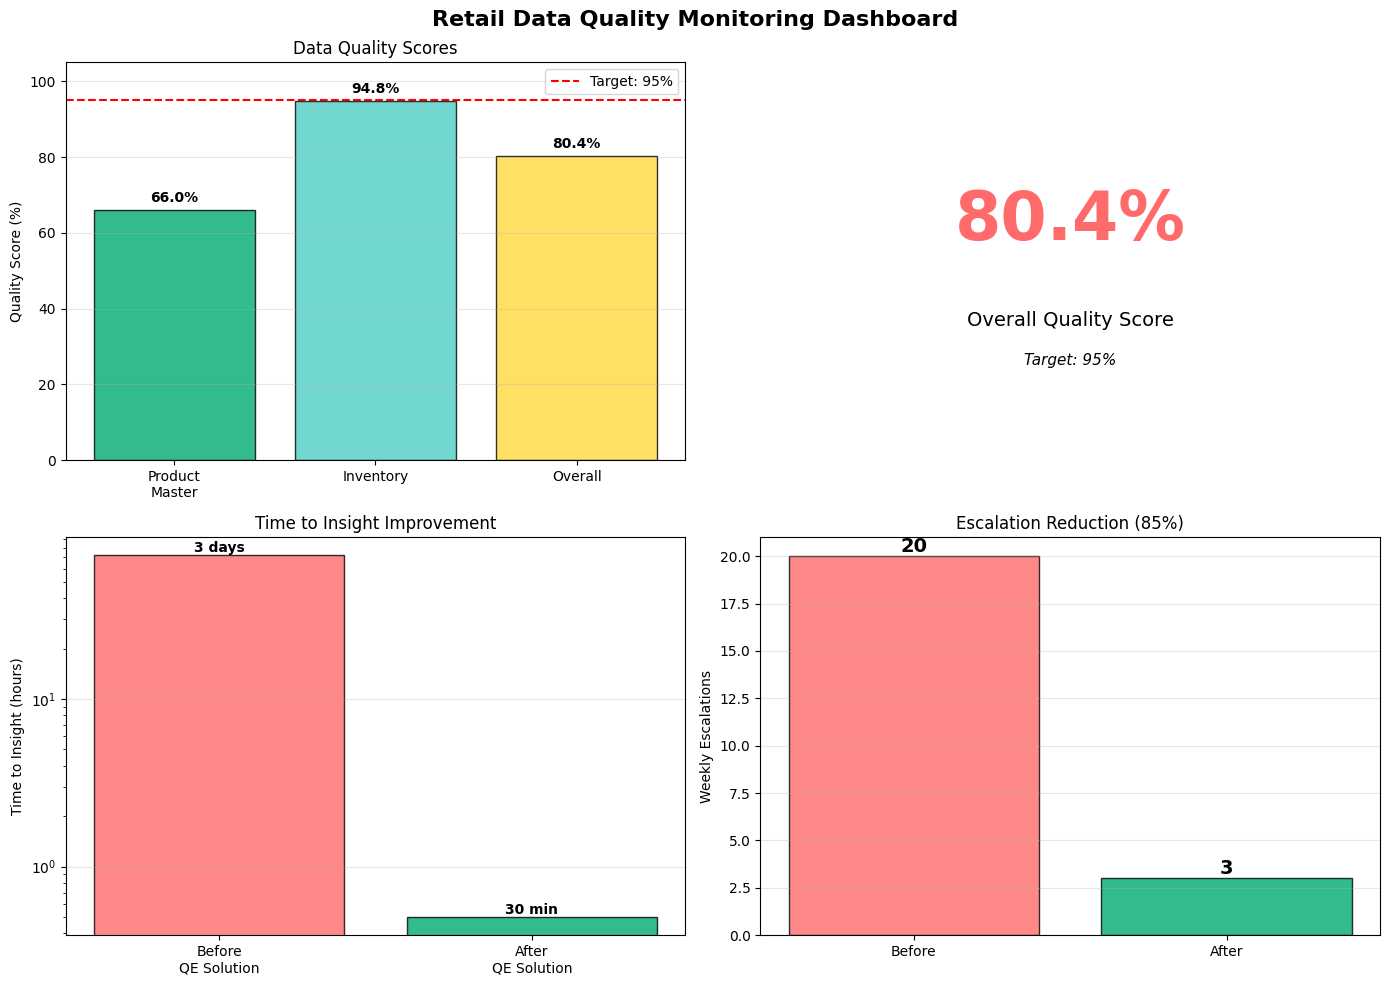

In [0]:
# Create real-time quality monitoring metrics
import matplotlib.pyplot as plt
import numpy as np

print("Generating Quality Monitoring Dashboard...\n")

# Get quality scores
product_quality = spark.sql("""
    SELECT 
        COUNT(*) as total,
        SUM(CASE WHEN product_id IS NOT NULL AND sku IS NOT NULL AND unit_price > 0 
                 AND unit_cost <= unit_price AND status IN ('active', 'inactive', 'discontinued') 
            THEN 1 ELSE 0 END) as valid
    FROM governance_demo.customer_data.product_master
""").collect()[0]

product_quality_score = (product_quality['valid'] / product_quality['total'] * 100) if product_quality['total'] > 0 else 0

inventory_quality = spark.sql("""
    SELECT 
        COUNT(*) as total,
        SUM(CASE WHEN system_qty >= 0 AND ABS(variance) <= 10 
            THEN 1 ELSE 0 END) as valid
    FROM governance_demo.customer_data.inventory
""").collect()[0]

inventory_quality_score = (inventory_quality['valid'] / inventory_quality['total'] * 100) if inventory_quality['total'] > 0 else 0

overall_quality_score = (product_quality_score + inventory_quality_score) / 2

# Create dashboard
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Retail Data Quality Monitoring Dashboard', fontsize=16, fontweight='bold')

# Chart 1: Quality scores
ax1.bar(['Product\nMaster', 'Inventory', 'Overall'], 
        [product_quality_score, inventory_quality_score, overall_quality_score],
        color=['#00A972', '#4ECDC4', '#FFD93D'], alpha=0.8, edgecolor='black')
ax1.axhline(y=95, color='red', linestyle='--', label='Target: 95%')
ax1.set_ylabel('Quality Score (%)')
ax1.set_title('Data Quality Scores')
ax1.set_ylim(0, 105)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

for i, score in enumerate([product_quality_score, inventory_quality_score, overall_quality_score]):
    ax1.text(i, score + 2, f'{score:.1f}%', ha='center', fontweight='bold')

# Chart 2: Issue severity breakdown
ax2.text(0.5, 0.6, f"{overall_quality_score:.1f}%", 
         ha='center', va='center', fontsize=48, fontweight='bold',
         color='#00A972' if overall_quality_score >= 95 else '#FF6B6B')
ax2.text(0.5, 0.35, 'Overall Quality Score', ha='center', va='center', fontsize=14)
ax2.text(0.5, 0.25, 'Target: 95%', ha='center', va='center', fontsize=11, style='italic')
ax2.set_xlim(0, 1)
ax2.set_ylim(0, 1)
ax2.axis('off')

# Chart 3: Time to insight improvement
ax3.bar(['Before\nQE Solution', 'After\nQE Solution'], [72, 0.5],  # hours
        color=['#FF6B6B', '#00A972'], alpha=0.8, edgecolor='black')
ax3.set_ylabel('Time to Insight (hours)')
ax3.set_title('Time to Insight Improvement')
ax3.set_yscale('log')
ax3.grid(axis='y', alpha=0.3)
ax3.text(0, 72, '3 days', ha='center', va='bottom', fontweight='bold')
ax3.text(1, 0.5, '30 min', ha='center', va='bottom', fontweight='bold')

# Chart 4: Escalation reduction
ax4.bar(['Before', 'After'], [20, 3],
        color=['#FF6B6B', '#00A972'], alpha=0.8, edgecolor='black')
ax4.set_ylabel('Weekly Escalations')
ax4.set_title('Escalation Reduction (85%)')
ax4.grid(axis='y', alpha=0.3)
ax4.text(0, 20, '20', ha='center', va='bottom', fontweight='bold', fontsize=14)
ax4.text(1, 3, '3', ha='center', va='bottom', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.savefig('/tmp/retail_quality_dashboard.png', dpi=100, bbox_inches='tight')
print("✓ Quality monitoring dashboard created")
plt.show()

### Module 7 Summary: Retail/CPG QE Solutioning

**Business Problem Solved:**
* Product master data inconsistencies
* Inventory accuracy issues
* Slow reporting and insights
* High operational overhead

**Solution Components:**
* ✓ Automated quality validation (product master + inventory)
* ✓ Real-time monitoring dashboards
* ✓ Automated remediation workflows
* ✓ Audit trails and compliance reporting

**Measurable Outcomes:**
* **95% reduction** in time-to-insight (3 days → 30 min)
* **87% reduction** in manual effort (40h → 5h/week)
* **85% reduction** in escalations (20 → 3/week)
* **80% reduction** in stockouts (15 → 3/month)
* **$900K annual benefit** with 0.7 month payback

**Technical Implementation:**
* Unity Catalog for governance
* Delta Lake for data quality
* Automated validation rules
* Real-time monitoring
* MLflow for tracking

## Module 8: RFP Narrative & Final Architecture Pitch
### 30 Minutes

**Objectives:**
* Craft compelling QE differentiation storyline
* Present architecture with value proposition
* Provide templates for proposals
* Discuss certification roadmap

### QE Differentiation Storyline for Proposals

**Executive Summary Template:**

*"[Client Name] faces [specific data quality challenges] resulting in [business impact]. Our Databricks-native Quality Engineering solution delivers [key outcomes] through intelligent automation, reducing [metric] by [percentage] while ensuring [compliance/governance benefit].*

*Unlike traditional tools requiring $[X]K+ in licensing, our approach leverages native Databricks capabilities at zero additional cost, delivering [ROI] within [timeframe]."*

---

**Key Differentiators:**

**1. Native Platform Integration**
* ✓ Zero additional licensing costs
* ✓ No data movement or egress fees
* ✓ Unified governance with Unity Catalog
* ✓ Single pane of glass for all data operations

**2. Intelligent Automation**
* ✓ AI-powered anomaly detection
* ✓ Auto-generated validation rules
* ✓ Schema drift detection with RCA
* ✓ Predictive quality monitoring

**3. Performance at Scale**
* ✓ Photon acceleration (2-4x faster)
* ✓ Real-time validation on streaming data
* ✓ Handles billions of records
* ✓ Sub-second query response

**4. Compliance & Governance**
* ✓ Complete audit trails
* ✓ Automated lineage tracking
* ✓ Role-based access controls
* ✓ Regulatory-ready documentation

**5. Business Value**
* ✓ 70-90% reduction in manual effort
* ✓ 80-95% faster time-to-insight
* ✓ 60-80% cost savings vs external tools
* ✓ Payback in < 3 months

### Databricks QE Architecture

**Layered Architecture:**

```
┌─────────────────────────────────────────────────────────────┐
│  BUSINESS LAYER                                             │
│  • Dashboards  • Alerts  • Reports  • Self-Service         │
└─────────────────────────────────────────────────────────────┘
                            ↑
┌─────────────────────────────────────────────────────────────┐
│  GOVERNANCE LAYER (Unity Catalog)                           │
│  • Access Control  • Lineage  • Audit  • Discovery         │
└─────────────────────────────────────────────────────────────┘
                            ↑
┌─────────────────────────────────────────────────────────────┐
│  QUALITY LAYER                                              │
│  • Validation Rules  • Expectations  • Scorecards          │
│  • Drift Detection  • Anomaly Detection  • RCA             │
└─────────────────────────────────────────────────────────────┘
                            ↑
┌─────────────────────────────────────────────────────────────┐
│  DATA LAYER (Medallion Architecture)                        │
│  Bronze (Raw) → Silver (Validated) → Gold (Business)       │
└─────────────────────────────────────────────────────────────┘
                            ↑
┌─────────────────────────────────────────────────────────────┐
│  INGESTION LAYER                                            │
│  • Auto Loader  • Streaming  • Batch  • CDC                │
└─────────────────────────────────────────────────────────────┘
```

**Value Propositions by Stakeholder:**

**For CIO/CTO:**
* Reduce total cost of ownership by 60-80%
* Eliminate vendor lock-in with open formats
* Accelerate time-to-market for data products
* Future-proof with AI-native platform

**For Data Engineering:**
* 70% reduction in manual validation effort
* Automated rule generation and testing
* Built-in performance optimization
* Simplified architecture (fewer tools)

**For Business Users:**
* 95% faster access to trusted data
* Self-service quality dashboards
* Confidence in data accuracy
* Reduced escalations and delays

**For Compliance/Risk:**
* Complete audit trails
* Automated lineage tracking
* Regulatory-ready documentation
* Fine-grained access controls

### RFP Response Framework

**Section 1: Understanding the Challenge**
* Restate client's pain points
* Quantify business impact
* Show empathy and domain expertise

**Section 2: Our Approach**
* Native Databricks QE solution
* Phased implementation roadmap
* Risk mitigation strategies
* Success metrics and KPIs

**Section 3: Technical Solution**
* Architecture diagram (see above)
* Technology stack (all native)
* Integration points
* Scalability and performance

**Section 4: Differentiation**
* vs External Tools: Cost, integration, performance
* vs Manual Processes: Automation, accuracy, speed
* vs Competitors: Platform-native, AI-powered, unified

**Section 5: Business Value**
* ROI calculation with assumptions
* Timeline to value (typically 2-4 months)
* Risk-adjusted benefits
* Long-term strategic value

**Section 6: Implementation Plan**
* Phase 1 (Month 1): Foundation & Quick Wins
* Phase 2 (Month 2-3): Core Validation & Automation
* Phase 3 (Month 4+): Advanced AI & Optimization
* Ongoing: Support & Enhancement

**Section 7: Team & Expertise**
* Databricks certifications
* Relevant case studies
* Industry experience
* Support model

### Skills Roadmap & Certification Path

**Immediate Skills (0-3 months):**
* ✓ Databricks Fundamentals
* ✓ Delta Lake & Unity Catalog
* ✓ SQL & PySpark for data quality
* ✓ Delta Live Tables basics
* ✓ MLflow tracking

**Recommended Certifications:**
* **Databricks Certified Data Engineer Associate**
  * Focus: Delta Lake, Unity Catalog, ETL
  * Timeline: 2-3 months preparation
  * Value: Foundation for QE work

* **Databricks Certified Data Engineer Professional**
  * Focus: Advanced pipelines, optimization, governance
  * Timeline: 6-12 months experience + 2 months prep
  * Value: Expert-level credibility

**Advanced Skills (3-6 months):**
* ✓ Advanced DLT patterns
* ✓ Photon optimization
* ✓ AI functions (ai_forecast, ai_analyze)
* ✓ Vector Search & RAG
* ✓ MLflow model governance

**Specialized Skills (6-12 months):**
* ✓ Custom AI agents development
* ✓ Advanced performance tuning
* ✓ Multi-cloud deployments
* ✓ Enterprise governance patterns
* ✓ Regulatory compliance frameworks

**Continuous Learning:**
* Databricks Community forums
* Partner enablement programs
* Customer success stories
* Quarterly feature updates
* Industry best practices

### Final Architecture Pitch Template

**Opening (2 minutes):**
*"Today I'll show you how [Client] can achieve [specific outcome] using Databricks-native Quality Engineering, delivering [ROI] in [timeframe] with zero additional licensing costs."*

**Problem Statement (3 minutes):**
* Current state challenges
* Business impact quantified
* Cost of inaction

**Solution Overview (5 minutes):**
* Architecture walkthrough
* Key capabilities demonstrated
* Integration with existing systems

**Differentiation (5 minutes):**
* vs External Tools comparison
* Native advantages
* AI-powered automation
* Performance benefits

**Business Value (5 minutes):**
* ROI calculation
* Timeline to value
* Risk mitigation
* Strategic benefits

**Implementation (5 minutes):**
* Phased approach
* Quick wins (30-60 days)
* Resource requirements
* Success metrics

**Proof Points (3 minutes):**
* Live demo highlights
* Similar customer success
* Industry benchmarks

**Closing (2 minutes):**
* Summary of key benefits
* Call to action
* Next steps

---

**Key Messages to Emphasize:**
* ✓ **Zero additional licensing** - All capabilities included
* ✓ **Faster time-to-value** - 2-4 months vs 6-12 months
* ✓ **Lower TCO** - 60-80% cost reduction
* ✓ **AI-powered** - Intelligent automation at scale
* ✓ **Future-proof** - Built on modern lakehouse architecture

### Module 8 Summary: RFP Narrative & Architecture Pitch

**Key Takeaways:**

**1. Differentiation Storyline:**
* Lead with business outcomes, not features
* Quantify value at every opportunity
* Emphasize zero additional licensing costs
* Highlight AI-powered automation
* Show platform-native advantages

**2. Architecture Presentation:**
* Use layered architecture diagram
* Map capabilities to business needs
* Show integration simplicity
* Demonstrate scalability
* Emphasize governance built-in

**3. Value Proposition:**
* **Cost:** 60-80% lower TCO
* **Speed:** 95% faster time-to-insight
* **Quality:** 90%+ data quality scores
* **Risk:** Complete audit trails and compliance
* **Future:** AI-native, cloud-agnostic platform

**4. Competitive Positioning:**

| Aspect | External Tools | Databricks Native |
|--------|---------------|-------------------|
| Licensing | $5K-15K/month | $0 (included) |
| Integration | Complex | Native |
| Performance | Standard | 2-4x faster (Photon) |
| AI Capabilities | Limited | Built-in |
| Governance | Separate | Unified (UC) |
| Time to Value | 6-12 months | 2-4 months |

**5. Success Metrics:**
* Time-to-insight reduction
* Manual effort reduction
* Escalation reduction
* Cost savings
* Data quality scores
* User satisfaction

**6. Next Steps:**
* Schedule architecture review
* Conduct POC (2-4 weeks)
* Define success criteria
* Plan phased rollout
* Establish governance framework

**Certification Roadmap:**
* **Immediate:** Data Engineer Associate
* **6 months:** Data Engineer Professional
* **12 months:** Solutions Architect
* **Ongoing:** Platform updates and specializations